# 1 - Multilayer Perceptron For Taxi Prediction

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import copy
import random
import time
import math 

# RNG SEED

In [2]:
SEED = 12345

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
class CustomDataset(Dataset):
    def __init__(self, train):
        self.train_data = torch.tensor(pd.read_csv(train).astype('float32').values)
        self.targets = torch.tensor(pd.read_csv("targets_engineered.csv").astype('float32').values)

    def __len__(self):
        return len(self.train_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        return self.train_data[idx], self.targets[idx]

The first thing we'll do is load our dataset.

This will automatically download the training set for the MNIST dataset and save it in a folder called `.data`. It will create the folder if it does not exist.

In [4]:
train_data = CustomDataset("train_engineered.csv")

In [5]:
#train_data.features

In [6]:
train_data[0]

(tensor([  0.0000,   0.0000,   1.0000,   0.0000,   0.0000,   0.0000, 691.6916,
           0.0000,  60.0000]),
 tensor([330.]))

We can simply check the `len` of the datasets to see how many examples are within each.

In [7]:
print(f'Number of training examples: {len(train_data)}')

Number of training examples: 1710670


In [8]:
VALID_RATIO = 0.75

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

In [9]:
train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

TEST_RATIO = 0.95
n_valid_examples = int(len(valid_data) * VALID_RATIO)
n_test_examples = len(valid_data) - n_valid_examples
valid_data, test_data = data.random_split(valid_data,
                                           [n_valid_examples, n_test_examples])

In [10]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 1283002
Number of validation examples: 320751
Number of testing examples: 106917


# BATCH SIZE

In [11]:
BATCH_SIZE = 3200

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

In [12]:
x, y = next(iter(train_iterator))
print(x)
print(y)

tensor([[0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 8.6678e+02, 3.0000e+00,
         1.0340e+03],
        [1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.8455e+02, 0.0000e+00,
         6.3400e+02],
        [0.0000e+00, 0.0000e+00, 1.0000e+00,  ..., 6.7863e+02, 3.0000e+00,
         1.0700e+02],
        ...,
        [1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 8.5785e+02, 1.0000e+00,
         8.8300e+02],
        [0.0000e+00, 0.0000e+00, 1.0000e+00,  ..., 7.2176e+02, 6.0000e+00,
         1.2240e+03],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 6.5102e+02, 6.0000e+00,
         1.1930e+03]])
tensor([[675.],
        [855.],
        [450.],
        ...,
        [930.],
        [ 60.],
        [615.]])


In [13]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers, dropout_rate, activation='leaky_relu'):
        super().__init__()

        self.layers = nn.ModuleList()
        self.activations = {'relu': F.relu, 'leaky_relu': F.leaky_relu}

        previous_layer_dim = input_dim
        for i in range(len(hidden_layers)):
            self.layers.append(nn.Linear(previous_layer_dim, hidden_layers[i]))
            self.layers.append(nn.BatchNorm1d(hidden_layers[i]))
            self.layers.append(nn.Dropout(dropout_rate[i]))
            previous_layer_dim = hidden_layers[i]

        self.layers.append(nn.Linear(previous_layer_dim, output_dim))

        assert activation in self.activations, f"Activation function {activation} not supported. Available activations: {list(self.activations.keys())}"
        self.activation = self.activations[activation]

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)

        for i, layer in enumerate(self.layers[:-1]):  # Exclude last layer
            if isinstance(layer, nn.Linear):
                x = layer(x)
                if i < len(self.layers) - 2:  # Not applying activation to the output layer
                    x = self.activation(x)

        h_2 = x
        y_pred = self.layers[-1](h_2)  # Final output

        return y_pred, h_2

In [14]:
INPUT_DIM = 9
OUTPUT_DIM = 1
HIDDEN_DIMS =  [1000, 500, 250, 100, 50]
dropout_rates = [0.5, 0.4, 0.3, 0.2, 0.1]

model = MLP(INPUT_DIM, OUTPUT_DIM, HIDDEN_DIMS, dropout_rates)

In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [16]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 669,751 trainable parameters


# LOSS FUNCTION

In [17]:
criterion = nn.MSELoss()

We then define `device`. This is used to place your model and data on to a GPU, if you have one.

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

We place our model and criterion on to the device by using the `.to` method.

In [19]:
model = model.to(device)
criterion = criterion.to(device)

# OPTIMIZER

In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)

Next, we'll define a function to calculate the accuracy of our model. This takes the index of the highest value for your prediction and compares it against the actual class label. We then divide how many our model got correct by the amount in the batch to calculate accuracy across the batch.

In [21]:
def calculate_accuracy(y_pred, y):
    '''top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]'''
    return 0 #acc

In [22]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += 0 #acc.item()


    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [23]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += 0 #acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

The final step before training is to define a small function to tell us how long an epoch took.

In [24]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

We're finally ready to train!

During each epoch we calculate the training loss and accuracy, followed by the validation loss and accuracy. We then check if the validation loss achieved is the best validation loss we have seen. If so, we save our model's parameters (called a `state_dict`).

# NUMBER OF EPOCHS

In [25]:
EPOCHS = 100

best_valid_loss = float('inf')
loss_values = []

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    
    #Append RMSE per epoch
    loss_values.append(math.sqrt(train_loss))

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'final-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

  0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 20s
	Train Loss: 459128.088 | Train Acc: 0.00%
	 Val. Loss: 411017.803 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 20s
	Train Loss: 450460.158 | Train Acc: 0.00%
	 Val. Loss: 413146.489 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 19s
	Train Loss: 450202.998 | Train Acc: 0.00%
	 Val. Loss: 410289.411 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 19s
	Train Loss: 448909.372 | Train Acc: 0.00%
	 Val. Loss: 409080.075 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 19s
	Train Loss: 447903.661 | Train Acc: 0.00%
	 Val. Loss: 408503.898 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 19s
	Train Loss: 447202.022 | Train Acc: 0.00%
	 Val. Loss: 407445.488 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 17s
	Train Loss: 446026.838 | Train Acc: 0.00%
	 Val. Loss: 406513.966 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 19s
	Train Loss: 445327.464 | Train Acc: 0.00%
	 Val. Loss: 406174.101 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 17s
	Train Loss: 444486.383 | Train Acc: 0.00%
	 Val. Loss: 404629.647 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 16s
	Train Loss: 444294.825 | Train Acc: 0.00%
	 Val. Loss: 404208.806 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 16s
	Train Loss: 443781.898 | Train Acc: 0.00%
	 Val. Loss: 406334.259 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 17s
	Train Loss: 443567.252 | Train Acc: 0.00%
	 Val. Loss: 403813.145 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 16s
	Train Loss: 443795.778 | Train Acc: 0.00%
	 Val. Loss: 404119.051 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 16s
	Train Loss: 442981.004 | Train Acc: 0.00%
	 Val. Loss: 404432.949 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 17s
	Train Loss: 442945.176 | Train Acc: 0.00%
	 Val. Loss: 404275.509 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 16s
	Train Loss: 443062.378 | Train Acc: 0.00%
	 Val. Loss: 403680.856 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 18s
	Train Loss: 442928.085 | Train Acc: 0.00%
	 Val. Loss: 404244.310 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 18s
	Train Loss: 442870.052 | Train Acc: 0.00%
	 Val. Loss: 402797.962 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0m 17s
	Train Loss: 442436.738 | Train Acc: 0.00%
	 Val. Loss: 402689.632 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 17s
	Train Loss: 442580.102 | Train Acc: 0.00%
	 Val. Loss: 403477.580 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 21 | Epoch Time: 0m 17s
	Train Loss: 442506.350 | Train Acc: 0.00%
	 Val. Loss: 402281.397 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 22 | Epoch Time: 0m 17s
	Train Loss: 442222.312 | Train Acc: 0.00%
	 Val. Loss: 404763.275 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 23 | Epoch Time: 0m 17s
	Train Loss: 441877.356 | Train Acc: 0.00%
	 Val. Loss: 402158.821 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 24 | Epoch Time: 0m 17s
	Train Loss: 441761.715 | Train Acc: 0.00%
	 Val. Loss: 402261.629 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 25 | Epoch Time: 0m 17s
	Train Loss: 441518.554 | Train Acc: 0.00%
	 Val. Loss: 402275.084 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 26 | Epoch Time: 0m 17s
	Train Loss: 441484.236 | Train Acc: 0.00%
	 Val. Loss: 407784.019 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 27 | Epoch Time: 0m 17s
	Train Loss: 441543.521 | Train Acc: 0.00%
	 Val. Loss: 402000.588 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 28 | Epoch Time: 0m 17s
	Train Loss: 441175.262 | Train Acc: 0.00%
	 Val. Loss: 400941.339 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 29 | Epoch Time: 0m 17s
	Train Loss: 440841.869 | Train Acc: 0.00%
	 Val. Loss: 400734.270 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 30 | Epoch Time: 0m 17s
	Train Loss: 440954.124 | Train Acc: 0.00%
	 Val. Loss: 401436.945 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 31 | Epoch Time: 0m 17s
	Train Loss: 440765.976 | Train Acc: 0.00%
	 Val. Loss: 401321.771 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 32 | Epoch Time: 0m 17s
	Train Loss: 440565.007 | Train Acc: 0.00%
	 Val. Loss: 401701.319 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 33 | Epoch Time: 0m 17s
	Train Loss: 440708.847 | Train Acc: 0.00%
	 Val. Loss: 400846.543 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 34 | Epoch Time: 0m 19s
	Train Loss: 440285.576 | Train Acc: 0.00%
	 Val. Loss: 400155.295 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 35 | Epoch Time: 0m 17s
	Train Loss: 440274.729 | Train Acc: 0.00%
	 Val. Loss: 402819.017 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 36 | Epoch Time: 0m 17s
	Train Loss: 440204.456 | Train Acc: 0.00%
	 Val. Loss: 399844.208 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 37 | Epoch Time: 0m 17s
	Train Loss: 439711.552 | Train Acc: 0.00%
	 Val. Loss: 399142.900 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 38 | Epoch Time: 0m 17s
	Train Loss: 440085.209 | Train Acc: 0.00%
	 Val. Loss: 400571.059 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 39 | Epoch Time: 0m 18s
	Train Loss: 439535.676 | Train Acc: 0.00%
	 Val. Loss: 401416.099 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 40 | Epoch Time: 0m 17s
	Train Loss: 439370.714 | Train Acc: 0.00%
	 Val. Loss: 404034.631 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 41 | Epoch Time: 0m 17s
	Train Loss: 439491.089 | Train Acc: 0.00%
	 Val. Loss: 399893.011 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 42 | Epoch Time: 0m 17s
	Train Loss: 439237.097 | Train Acc: 0.00%
	 Val. Loss: 399547.208 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 43 | Epoch Time: 0m 17s
	Train Loss: 439157.443 | Train Acc: 0.00%
	 Val. Loss: 399267.730 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 44 | Epoch Time: 0m 17s
	Train Loss: 438948.930 | Train Acc: 0.00%
	 Val. Loss: 400092.336 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 45 | Epoch Time: 0m 17s
	Train Loss: 439013.577 | Train Acc: 0.00%
	 Val. Loss: 402484.294 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 46 | Epoch Time: 0m 17s
	Train Loss: 438621.196 | Train Acc: 0.00%
	 Val. Loss: 398938.555 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 47 | Epoch Time: 0m 18s
	Train Loss: 438748.664 | Train Acc: 0.00%
	 Val. Loss: 400626.389 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 48 | Epoch Time: 0m 17s
	Train Loss: 438544.853 | Train Acc: 0.00%
	 Val. Loss: 401356.198 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 49 | Epoch Time: 0m 18s
	Train Loss: 437994.504 | Train Acc: 0.00%
	 Val. Loss: 404406.131 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 50 | Epoch Time: 0m 17s
	Train Loss: 438572.508 | Train Acc: 0.00%
	 Val. Loss: 399020.168 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 51 | Epoch Time: 0m 17s
	Train Loss: 438199.738 | Train Acc: 0.00%
	 Val. Loss: 399067.314 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 52 | Epoch Time: 0m 19s
	Train Loss: 438088.019 | Train Acc: 0.00%
	 Val. Loss: 397721.612 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 53 | Epoch Time: 0m 21s
	Train Loss: 437774.147 | Train Acc: 0.00%
	 Val. Loss: 400223.998 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 54 | Epoch Time: 0m 18s
	Train Loss: 437949.883 | Train Acc: 0.00%
	 Val. Loss: 398730.164 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 55 | Epoch Time: 0m 17s
	Train Loss: 437922.606 | Train Acc: 0.00%
	 Val. Loss: 401254.573 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 56 | Epoch Time: 0m 18s
	Train Loss: 437635.259 | Train Acc: 0.00%
	 Val. Loss: 397747.047 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 57 | Epoch Time: 0m 17s
	Train Loss: 437670.883 | Train Acc: 0.00%
	 Val. Loss: 397873.774 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 58 | Epoch Time: 0m 17s
	Train Loss: 437207.407 | Train Acc: 0.00%
	 Val. Loss: 397801.985 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 59 | Epoch Time: 0m 17s
	Train Loss: 436984.613 | Train Acc: 0.00%
	 Val. Loss: 397344.011 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 60 | Epoch Time: 0m 17s
	Train Loss: 437338.780 | Train Acc: 0.00%
	 Val. Loss: 397502.920 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 61 | Epoch Time: 0m 18s
	Train Loss: 437019.151 | Train Acc: 0.00%
	 Val. Loss: 396608.814 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 62 | Epoch Time: 0m 17s
	Train Loss: 437134.799 | Train Acc: 0.00%
	 Val. Loss: 399953.010 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 63 | Epoch Time: 0m 17s
	Train Loss: 436772.273 | Train Acc: 0.00%
	 Val. Loss: 396545.871 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 64 | Epoch Time: 0m 18s
	Train Loss: 437080.785 | Train Acc: 0.00%
	 Val. Loss: 396713.148 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 65 | Epoch Time: 0m 18s
	Train Loss: 436231.641 | Train Acc: 0.00%
	 Val. Loss: 402195.400 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 66 | Epoch Time: 0m 17s
	Train Loss: 436895.920 | Train Acc: 0.00%
	 Val. Loss: 399619.209 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 67 | Epoch Time: 0m 20s
	Train Loss: 436619.152 | Train Acc: 0.00%
	 Val. Loss: 396856.149 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 68 | Epoch Time: 0m 17s
	Train Loss: 436388.162 | Train Acc: 0.00%
	 Val. Loss: 399390.117 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 69 | Epoch Time: 0m 18s
	Train Loss: 436506.671 | Train Acc: 0.00%
	 Val. Loss: 397955.896 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 70 | Epoch Time: 0m 17s
	Train Loss: 437391.224 | Train Acc: 0.00%
	 Val. Loss: 397666.462 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 71 | Epoch Time: 0m 17s
	Train Loss: 436457.829 | Train Acc: 0.00%
	 Val. Loss: 396041.947 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 72 | Epoch Time: 0m 19s
	Train Loss: 436388.325 | Train Acc: 0.00%
	 Val. Loss: 396584.853 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 73 | Epoch Time: 0m 17s
	Train Loss: 436568.750 | Train Acc: 0.00%
	 Val. Loss: 396927.109 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 74 | Epoch Time: 0m 18s
	Train Loss: 436004.887 | Train Acc: 0.00%
	 Val. Loss: 396224.308 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 75 | Epoch Time: 0m 17s
	Train Loss: 436071.501 | Train Acc: 0.00%
	 Val. Loss: 398585.187 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 76 | Epoch Time: 0m 17s
	Train Loss: 436144.749 | Train Acc: 0.00%
	 Val. Loss: 397122.860 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 77 | Epoch Time: 0m 17s
	Train Loss: 436123.424 | Train Acc: 0.00%
	 Val. Loss: 396839.373 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 78 | Epoch Time: 0m 19s
	Train Loss: 435955.464 | Train Acc: 0.00%
	 Val. Loss: 396204.750 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 79 | Epoch Time: 0m 18s
	Train Loss: 436419.580 | Train Acc: 0.00%
	 Val. Loss: 397078.333 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 80 | Epoch Time: 0m 18s
	Train Loss: 436014.038 | Train Acc: 0.00%
	 Val. Loss: 396334.571 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 81 | Epoch Time: 0m 17s
	Train Loss: 436397.220 | Train Acc: 0.00%
	 Val. Loss: 396347.766 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 82 | Epoch Time: 0m 17s
	Train Loss: 435666.076 | Train Acc: 0.00%
	 Val. Loss: 396200.576 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 83 | Epoch Time: 0m 17s
	Train Loss: 435751.313 | Train Acc: 0.00%
	 Val. Loss: 396855.378 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 84 | Epoch Time: 0m 17s
	Train Loss: 435717.409 | Train Acc: 0.00%
	 Val. Loss: 396284.097 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 85 | Epoch Time: 0m 17s
	Train Loss: 436200.513 | Train Acc: 0.00%
	 Val. Loss: 396358.216 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 86 | Epoch Time: 0m 17s
	Train Loss: 435134.402 | Train Acc: 0.00%
	 Val. Loss: 400092.688 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 87 | Epoch Time: 0m 19s
	Train Loss: 435246.673 | Train Acc: 0.00%
	 Val. Loss: 397014.250 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 88 | Epoch Time: 0m 17s
	Train Loss: 435352.320 | Train Acc: 0.00%
	 Val. Loss: 395236.940 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 89 | Epoch Time: 0m 17s
	Train Loss: 436231.778 | Train Acc: 0.00%
	 Val. Loss: 396354.141 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 90 | Epoch Time: 0m 17s
	Train Loss: 435234.830 | Train Acc: 0.00%
	 Val. Loss: 396239.884 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 91 | Epoch Time: 0m 17s
	Train Loss: 435252.315 | Train Acc: 0.00%
	 Val. Loss: 395530.766 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 92 | Epoch Time: 0m 16s
	Train Loss: 435030.958 | Train Acc: 0.00%
	 Val. Loss: 395151.987 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 93 | Epoch Time: 0m 17s
	Train Loss: 436427.581 | Train Acc: 0.00%
	 Val. Loss: 396529.140 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 94 | Epoch Time: 0m 17s
	Train Loss: 434982.582 | Train Acc: 0.00%
	 Val. Loss: 395332.281 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 95 | Epoch Time: 0m 17s
	Train Loss: 434928.276 | Train Acc: 0.00%
	 Val. Loss: 396359.503 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 96 | Epoch Time: 0m 17s
	Train Loss: 435104.029 | Train Acc: 0.00%
	 Val. Loss: 396048.498 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 97 | Epoch Time: 0m 17s
	Train Loss: 434896.137 | Train Acc: 0.00%
	 Val. Loss: 395876.637 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 98 | Epoch Time: 0m 17s
	Train Loss: 434836.773 | Train Acc: 0.00%
	 Val. Loss: 395197.700 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 99 | Epoch Time: 0m 17s
	Train Loss: 434911.544 | Train Acc: 0.00%
	 Val. Loss: 397017.053 |  Val. Acc: 0.00%


Training:   0%|          | 0/401 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 100 | Epoch Time: 0m 17s
	Train Loss: 434752.649 | Train Acc: 0.00%
	 Val. Loss: 396556.036 |  Val. Acc: 0.00%


In [38]:
def evaluate_final_train(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0
    
    all_data = []

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)
            
            #Save loss for each point
            data = [y_pred, y, loss]
            all_data.append(data)

            epoch_loss += loss.item()
            epoch_acc += 0 #acc.item()

    return all_data

In [67]:
all_data = evaluate_final_train(model, train_iterator, criterion, device)

Evaluating:   0%|          | 0/401 [00:00<?, ?it/s]

In [97]:
samples = random.sample(all_data, 100)

In [98]:
random_predictions = []
random_actuals = []
for i in range(len(samples)):
    point_index = random.randint(0,len(samples[i]))
    y_pred = samples[i][0][point_index]
    y_actual = samples[i][1][point_index]
    random_predictions.append(float(y_pred.cpu()))
    random_actuals.append(float(y_actual.cpu()))
# print(random_predictions)
# print(random_actuals)

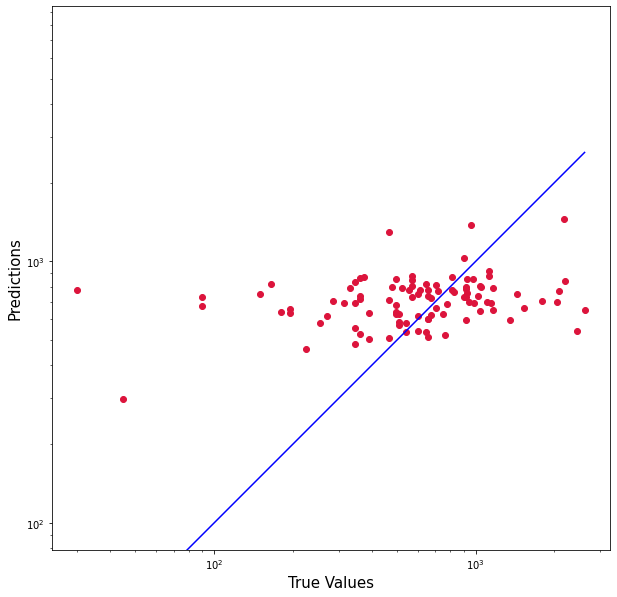

In [99]:
plt.figure(figsize=(10,10))
plt.scatter(random_actuals, random_predictions, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(random_predictions), max(random_actuals))
p2 = min(min(random_predictions), min(random_actuals))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [41]:
model.load_state_dict(torch.load('final-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Afterwards, we load our the parameters of the model that achieved the best validation loss and then use this to evaluate our model on the test set.

In [44]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 246619.703 | Test Acc: 0.00%


In [45]:
mse = test_loss
rmse = math.sqrt(mse)

print(f'Test Loss: {test_loss:.3f}')
print("Test RMSE:", rmse)

Test Loss: 246619.703
Test RMSE: 496.6081988096854


In [46]:
test_data = CustomDataset("test_engineered.csv")
test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

df_result = pd.read_csv("sampleSubmission.csv", index_col = False)

model.eval()

with torch.no_grad():

    for (x, y) in tqdm(test_iterator, desc="Evaluating", leave=False):

        x = x.to(device)
        y = y.to(device)

        y_pred, _ = model(x)
        
        df_result['TRAVEL_TIME'] = pd.DataFrame(y_pred.cpu().numpy())

df_result.to_csv("final_submission.csv", index=False)

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

In [47]:
df_result

,TRIP_ID,TRAVEL_TIME
0,T1,837.907349
1,T2,729.815796
2,T3,736.309631
3,T4,681.957642
4,T5,635.576111
...,...,...
315,T323,734.374146
316,T324,677.759277
317,T325,1100.304199
318,T326,739.796509


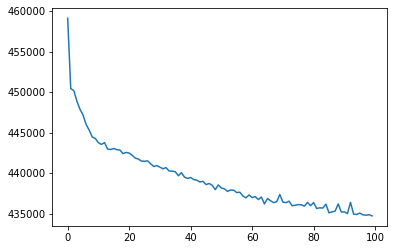

In [100]:
mse_values = [loss**2 for loss in loss_values]
plt.plot(mse_values)

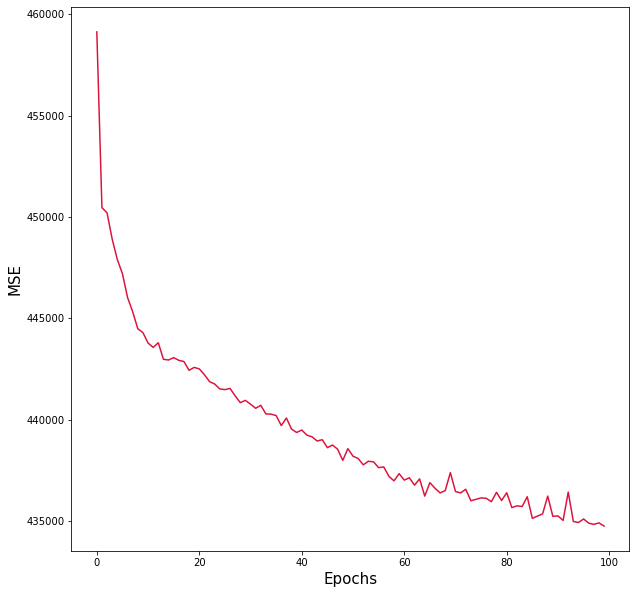

In [108]:
plt.figure(figsize=(10,10))
plt.plot([i for i in range(len(mse_values))], mse_values, c='crimson')

plt.xlabel('Epochs', fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.show()

In [107]:
len(mse_values)

100